In [1]:
from common.torch_utils import get_available_device

device = get_available_device()

Platform: Darwin
Release: 21.5.0
MPS available: True
CUDA available: False
Selected device: mps


In [2]:
from common.torch_utils import get_available_device

device = get_available_device()

import time
import torch
import torch.optim as optim

from fcos import FCOS
from fcos import FCOS
from dataset import LabelsCodec, build_dataloader
from fcos import FcosDetectionsEncoder
from fcos import build_backbone

img_res = (256, 256)
labels_codec = LabelsCodec()

model = FCOS(
    backbone=build_backbone('resnet50'),
    labels_codec=labels_codec,
    res=img_res,
)
model = model.train().to(device)
codec = FcosDetectionsEncoder(img_res, labels_codec)

train_dataloader = build_dataloader('train', batch_size=4)
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

loss_sample = []
for epoch in range(1):
    for step, (img, boxes, labels) in enumerate(train_dataloader):
        start_stamp = time.time()
        optimizer.zero_grad()

        targets = codec(boxes, labels)
        loss = model(img.to(device), targets)

        total_loss = sum([v for _, v in loss.items()])
        total_loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()
        loss_sample.append(total_loss)

        print(f"Step {step} Total loss: {total_loss}\t\tDuration: {time.time() - start_stamp}")
        print(f"\t\tLoss: {loss}")
        print()

print('Finished Training')


Platform: Darwin
Release: 21.5.0
MPS available: True
CUDA available: False
Selected device: mps


/Users/iolkhovsky/Documents/repos/fcos/dataset/loader.py:59: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  return torch.Tensor(images), bboxes, labels
/Users/iolkhovsky/Documents/repos/fcos/fcos/encoder.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_regression_value = max(torch.tensor(ltrb, dtype=torch.float))


Step 0 Total loss: 3.5333266258239746		Duration: 2.369953155517578
		Loss: {'classification': tensor(1.1778, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6651, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(1.6905, device='mps:0', grad_fn=<DivBackward0>)}



/Users/iolkhovsky/Documents/repos/fcos/venv/lib/python3.8/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(


Step 1 Total loss: 3.4838688373565674		Duration: 1.0050973892211914
		Loss: {'classification': tensor(1.1038, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6868, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(1.6933, device='mps:0', grad_fn=<DivBackward0>)}

Step 2 Total loss: 3.513167381286621		Duration: 1.1428160667419434
		Loss: {'classification': tensor(1.0919, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6886, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(1.7327, device='mps:0', grad_fn=<DivBackward0>)}

Step 3 Total loss: 3.4501986503601074		Duration: 1.1416029930114746
		Loss: {'classification': tensor(1.2851, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6971, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(1.4680, device='mps:0', grad_fn=<DivBackward0>)}

Step 4 Total loss: 3.560274600982666		Duration: 0.8652968406677246
		Loss: {'classification': tensor(1.1366, device='mps:0', 

Step 30 Total loss: 2.700592517852783		Duration: 0.9428930282592773
		Loss: {'classification': tensor(1.0715, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6822, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.9470, device='mps:0', grad_fn=<DivBackward0>)}

Step 31 Total loss: 2.5307297706604004		Duration: 1.004701852798462
		Loss: {'classification': tensor(0.8995, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6928, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.9384, device='mps:0', grad_fn=<DivBackward0>)}

Step 32 Total loss: 2.832447052001953		Duration: 0.9383740425109863
		Loss: {'classification': tensor(1.0638, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6562, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(1.1125, device='mps:0', grad_fn=<DivBackward0>)}

Step 33 Total loss: 2.4265713691711426		Duration: 0.971548318862915
		Loss: {'classification': tensor(0.9768, device='mps:0'

Step 59 Total loss: 2.5455210208892822		Duration: 1.0022928714752197
		Loss: {'classification': tensor(0.9886, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6715, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.8854, device='mps:0', grad_fn=<DivBackward0>)}

Step 60 Total loss: 2.5022401809692383		Duration: 0.9358599185943604
		Loss: {'classification': tensor(0.9854, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6453, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.8715, device='mps:0', grad_fn=<DivBackward0>)}

Step 61 Total loss: 2.4315521717071533		Duration: 1.133749008178711
		Loss: {'classification': tensor(0.8576, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6322, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.9418, device='mps:0', grad_fn=<DivBackward0>)}

Step 62 Total loss: 2.7030670642852783		Duration: 0.9175069332122803
		Loss: {'classification': tensor(0.9502, device='mps

Step 88 Total loss: 2.270528793334961		Duration: 1.1362779140472412
		Loss: {'classification': tensor(0.7899, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6535, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.8271, device='mps:0', grad_fn=<DivBackward0>)}

Step 89 Total loss: 2.5713775157928467		Duration: 0.9105970859527588
		Loss: {'classification': tensor(0.9426, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6523, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.9764, device='mps:0', grad_fn=<DivBackward0>)}

Step 90 Total loss: 2.580599069595337		Duration: 1.0516459941864014
		Loss: {'classification': tensor(0.9781, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6821, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.9204, device='mps:0', grad_fn=<DivBackward0>)}

Step 91 Total loss: 2.322633743286133		Duration: 1.0846590995788574
		Loss: {'classification': tensor(0.8947, device='mps:0

Step 117 Total loss: 2.4808812141418457		Duration: 0.783822774887085
		Loss: {'classification': tensor(1.0446, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6612, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.7751, device='mps:0', grad_fn=<DivBackward0>)}

Step 118 Total loss: 2.4408552646636963		Duration: 1.065284013748169
		Loss: {'classification': tensor(0.9228, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6198, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.8983, device='mps:0', grad_fn=<DivBackward0>)}

Step 119 Total loss: 2.571634292602539		Duration: 1.0102667808532715
		Loss: {'classification': tensor(0.9570, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6366, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.9780, device='mps:0', grad_fn=<DivBackward0>)}

Step 120 Total loss: 2.3442869186401367		Duration: 1.0000131130218506
		Loss: {'classification': tensor(1.1093, device='m

Step 145 Total loss: 2.151247501373291		Duration: 1.0761408805847168
		Loss: {'classification': tensor(0.7078, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6430, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.8005, device='mps:0', grad_fn=<DivBackward0>)}

Step 146 Total loss: 2.362086057662964		Duration: 0.850294828414917
		Loss: {'classification': tensor(0.8375, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6495, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.8750, device='mps:0', grad_fn=<DivBackward0>)}

Step 147 Total loss: 2.3670976161956787		Duration: 0.8309612274169922
		Loss: {'classification': tensor(0.7399, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6613, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.9659, device='mps:0', grad_fn=<DivBackward0>)}

Step 148 Total loss: 2.1081595420837402		Duration: 0.862238883972168
		Loss: {'classification': tensor(0.7617, device='mp

Step 173 Total loss: 2.40452241897583		Duration: 0.9595849514007568
		Loss: {'classification': tensor(0.7800, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6619, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.9626, device='mps:0', grad_fn=<DivBackward0>)}

Step 174 Total loss: 2.251774787902832		Duration: 1.0519449710845947
		Loss: {'classification': tensor(0.6838, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6552, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.9128, device='mps:0', grad_fn=<DivBackward0>)}

Step 175 Total loss: 2.1288022994995117		Duration: 0.7759430408477783
		Loss: {'classification': tensor(0.6355, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6652, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.8281, device='mps:0', grad_fn=<DivBackward0>)}

Step 176 Total loss: 1.9911677837371826		Duration: 1.3520450592041016
		Loss: {'classification': tensor(0.8533, device='m

Step 201 Total loss: 1.7469539642333984		Duration: 1.0060579776763916
		Loss: {'classification': tensor(0.5686, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.5845, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.5938, device='mps:0', grad_fn=<DivBackward0>)}

Step 202 Total loss: 2.4485836029052734		Duration: 1.318998098373413
		Loss: {'classification': tensor(0.7915, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6861, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.9710, device='mps:0', grad_fn=<DivBackward0>)}

Step 203 Total loss: 1.941575288772583		Duration: 1.0707881450653076
		Loss: {'classification': tensor(0.7550, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6089, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.5776, device='mps:0', grad_fn=<DivBackward0>)}

Step 204 Total loss: 2.2439441680908203		Duration: 0.9562680721282959
		Loss: {'classification': tensor(0.6799, device='

Step 229 Total loss: 2.2898614406585693		Duration: 1.2481529712677002
		Loss: {'classification': tensor(0.6825, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6575, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.9498, device='mps:0', grad_fn=<DivBackward0>)}

Step 230 Total loss: 2.36954927444458		Duration: 1.1087019443511963
		Loss: {'classification': tensor(0.7401, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6600, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.9695, device='mps:0', grad_fn=<DivBackward0>)}

Step 231 Total loss: 2.283486843109131		Duration: 0.7312748432159424
		Loss: {'classification': tensor(0.7408, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6873, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.8554, device='mps:0', grad_fn=<DivBackward0>)}

Step 232 Total loss: 2.2062697410583496		Duration: 1.1909079551696777
		Loss: {'classification': tensor(0.7957, device='m

Step 257 Total loss: 2.2932305335998535		Duration: 0.961698055267334
		Loss: {'classification': tensor(0.8336, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6271, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.8325, device='mps:0', grad_fn=<DivBackward0>)}

Step 258 Total loss: 2.0663883686065674		Duration: 1.0797581672668457
		Loss: {'classification': tensor(0.6863, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6288, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.7513, device='mps:0', grad_fn=<DivBackward0>)}

Step 259 Total loss: 2.407771587371826		Duration: 0.7443561553955078
		Loss: {'classification': tensor(0.8502, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6457, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.9119, device='mps:0', grad_fn=<DivBackward0>)}

Step 260 Total loss: 2.401901960372925		Duration: 1.2384071350097656
		Loss: {'classification': tensor(0.7260, device='m

Step 285 Total loss: 2.415116310119629		Duration: 0.8658318519592285
		Loss: {'classification': tensor(0.6317, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6637, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(1.1197, device='mps:0', grad_fn=<DivBackward0>)}

Step 286 Total loss: 2.196033477783203		Duration: 1.1835498809814453
		Loss: {'classification': tensor(0.5919, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6552, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.9489, device='mps:0', grad_fn=<DivBackward0>)}

Step 287 Total loss: 2.270538330078125		Duration: 0.9894027709960938
		Loss: {'classification': tensor(0.7395, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6614, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.8696, device='mps:0', grad_fn=<DivBackward0>)}

Step 288 Total loss: 2.372525691986084		Duration: 0.8470370769500732
		Loss: {'classification': tensor(0.6875, device='mp

Step 313 Total loss: 2.198101282119751		Duration: 0.8380610942840576
		Loss: {'classification': tensor(0.5938, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6697, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.9346, device='mps:0', grad_fn=<DivBackward0>)}

Step 314 Total loss: 2.4033281803131104		Duration: 0.9118809700012207
		Loss: {'classification': tensor(0.7259, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6668, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(1.0106, device='mps:0', grad_fn=<DivBackward0>)}

Step 315 Total loss: 2.2328639030456543		Duration: 1.1017870903015137
		Loss: {'classification': tensor(0.7581, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6391, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.8357, device='mps:0', grad_fn=<DivBackward0>)}

Step 316 Total loss: 1.8688247203826904		Duration: 0.897972822189331
		Loss: {'classification': tensor(0.6143, device='

Step 341 Total loss: 2.2288427352905273		Duration: 0.83677077293396
		Loss: {'classification': tensor(0.7910, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6208, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.8170, device='mps:0', grad_fn=<DivBackward0>)}

Step 342 Total loss: 2.2408664226531982		Duration: 0.8359899520874023
		Loss: {'classification': tensor(0.6670, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6828, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.8910, device='mps:0', grad_fn=<DivBackward0>)}

Step 343 Total loss: 2.3656601905822754		Duration: 1.0041780471801758
		Loss: {'classification': tensor(0.7877, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6542, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.9238, device='mps:0', grad_fn=<DivBackward0>)}

Step 344 Total loss: 2.0793492794036865		Duration: 1.1314799785614014
		Loss: {'classification': tensor(0.6778, device='

Step 369 Total loss: 2.316420793533325		Duration: 1.2251901626586914
		Loss: {'classification': tensor(0.8093, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6504, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.8567, device='mps:0', grad_fn=<DivBackward0>)}

Step 370 Total loss: 2.2142252922058105		Duration: 1.1376521587371826
		Loss: {'classification': tensor(0.6257, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6573, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.9312, device='mps:0', grad_fn=<DivBackward0>)}

Step 371 Total loss: 2.332099199295044		Duration: 1.1915168762207031
		Loss: {'classification': tensor(0.6776, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6711, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.9834, device='mps:0', grad_fn=<DivBackward0>)}

Step 372 Total loss: 2.2209062576293945		Duration: 0.894636869430542
		Loss: {'classification': tensor(0.6362, device='m

Step 397 Total loss: 2.620297431945801		Duration: 0.7254903316497803
		Loss: {'classification': tensor(0.9022, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6849, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(1.0332, device='mps:0', grad_fn=<DivBackward0>)}

Step 398 Total loss: 2.26971697807312		Duration: 1.089566946029663
		Loss: {'classification': tensor(0.5208, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6642, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(1.0846, device='mps:0', grad_fn=<DivBackward0>)}

Step 399 Total loss: 2.1590473651885986		Duration: 0.927952766418457
		Loss: {'classification': tensor(0.6475, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6567, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.8548, device='mps:0', grad_fn=<DivBackward0>)}

Step 400 Total loss: 2.2223398685455322		Duration: 0.9024758338928223
		Loss: {'classification': tensor(0.6110, device='mps

Step 425 Total loss: 2.1875803470611572		Duration: 0.7596280574798584
		Loss: {'classification': tensor(0.6429, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6604, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.8843, device='mps:0', grad_fn=<DivBackward0>)}

Step 426 Total loss: 2.2004647254943848		Duration: 1.0987200736999512
		Loss: {'classification': tensor(0.6803, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6717, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.8485, device='mps:0', grad_fn=<DivBackward0>)}

Step 427 Total loss: 2.00569486618042		Duration: 0.9379689693450928
		Loss: {'classification': tensor(0.5319, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6565, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.8173, device='mps:0', grad_fn=<DivBackward0>)}

Step 428 Total loss: 2.205918788909912		Duration: 1.1038339138031006
		Loss: {'classification': tensor(0.6313, device='m

Step 453 Total loss: 2.323046922683716		Duration: 0.9175910949707031
		Loss: {'classification': tensor(0.7798, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6705, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.8727, device='mps:0', grad_fn=<DivBackward0>)}

Step 454 Total loss: 2.2940289974212646		Duration: 0.8938560485839844
		Loss: {'classification': tensor(0.6928, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6497, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.9515, device='mps:0', grad_fn=<DivBackward0>)}

Step 455 Total loss: 2.170037269592285		Duration: 1.04408597946167
		Loss: {'classification': tensor(0.6860, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6626, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.8214, device='mps:0', grad_fn=<DivBackward0>)}

Step 456 Total loss: 1.9076651334762573		Duration: 0.9638359546661377
		Loss: {'classification': tensor(0.5014, device='mp

Step 481 Total loss: 2.236173629760742		Duration: 0.8549258708953857
		Loss: {'classification': tensor(0.5737, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6477, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(1.0148, device='mps:0', grad_fn=<DivBackward0>)}

Step 482 Total loss: 2.061373472213745		Duration: 1.0916101932525635
		Loss: {'classification': tensor(0.6185, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6440, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.7989, device='mps:0', grad_fn=<DivBackward0>)}

Step 483 Total loss: 2.092724323272705		Duration: 1.1937363147735596
		Loss: {'classification': tensor(0.7145, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6228, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.7554, device='mps:0', grad_fn=<DivBackward0>)}

Step 484 Total loss: 2.1313374042510986		Duration: 1.1863429546356201
		Loss: {'classification': tensor(0.5994, device='m

Step 509 Total loss: 2.2224669456481934		Duration: 0.809967041015625
		Loss: {'classification': tensor(0.6482, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6480, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.9263, device='mps:0', grad_fn=<DivBackward0>)}

Step 510 Total loss: 2.166076421737671		Duration: 0.8855898380279541
		Loss: {'classification': tensor(0.6757, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6330, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.8574, device='mps:0', grad_fn=<DivBackward0>)}

Step 511 Total loss: 1.844369649887085		Duration: 1.0091099739074707
		Loss: {'classification': tensor(0.5433, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6359, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.6651, device='mps:0', grad_fn=<DivBackward0>)}

Step 512 Total loss: 2.0536694526672363		Duration: 0.9627838134765625
		Loss: {'classification': tensor(0.7524, device='m

Step 537 Total loss: 2.036623954772949		Duration: 1.300266981124878
		Loss: {'classification': tensor(0.6161, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6442, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.7763, device='mps:0', grad_fn=<DivBackward0>)}

Step 538 Total loss: 1.9836580753326416		Duration: 1.120973825454712
		Loss: {'classification': tensor(0.6914, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6328, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.6595, device='mps:0', grad_fn=<DivBackward0>)}

Step 539 Total loss: 2.02699875831604		Duration: 0.9364757537841797
		Loss: {'classification': tensor(0.5682, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6519, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.8069, device='mps:0', grad_fn=<DivBackward0>)}

Step 540 Total loss: 1.7927372455596924		Duration: 1.0396509170532227
		Loss: {'classification': tensor(0.6532, device='mps

Step 565 Total loss: 1.7751531600952148		Duration: 0.9249238967895508
		Loss: {'classification': tensor(0.5414, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6210, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.6128, device='mps:0', grad_fn=<DivBackward0>)}

Step 566 Total loss: 1.8350752592086792		Duration: 1.1279869079589844
		Loss: {'classification': tensor(0.4848, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6366, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.7137, device='mps:0', grad_fn=<DivBackward0>)}

Step 567 Total loss: 2.097489356994629		Duration: 1.1540429592132568
		Loss: {'classification': tensor(0.7196, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6481, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.7298, device='mps:0', grad_fn=<DivBackward0>)}

Step 568 Total loss: 1.9298737049102783		Duration: 0.9520330429077148
		Loss: {'classification': tensor(0.6135, device=

Step 593 Total loss: 1.7953364849090576		Duration: 1.0926756858825684
		Loss: {'classification': tensor(0.5074, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6498, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.6381, device='mps:0', grad_fn=<DivBackward0>)}

Step 594 Total loss: 2.065868616104126		Duration: 0.7069549560546875
		Loss: {'classification': tensor(0.6854, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6350, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.7455, device='mps:0', grad_fn=<DivBackward0>)}

Step 595 Total loss: 1.6182907819747925		Duration: 1.1037371158599854
		Loss: {'classification': tensor(0.4729, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6177, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.5277, device='mps:0', grad_fn=<DivBackward0>)}

Step 596 Total loss: 2.036810874938965		Duration: 1.0286788940429688
		Loss: {'classification': tensor(0.6012, device='

Step 621 Total loss: 1.9077703952789307		Duration: 1.1342461109161377
		Loss: {'classification': tensor(0.5584, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6271, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.7223, device='mps:0', grad_fn=<DivBackward0>)}

Step 622 Total loss: 1.8496381044387817		Duration: 1.1349191665649414
		Loss: {'classification': tensor(0.6134, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6266, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.6096, device='mps:0', grad_fn=<DivBackward0>)}

Step 623 Total loss: 2.4371142387390137		Duration: 0.8304119110107422
		Loss: {'classification': tensor(0.7680, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6687, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(1.0004, device='mps:0', grad_fn=<DivBackward0>)}

Step 624 Total loss: 2.0699479579925537		Duration: 0.9985771179199219
		Loss: {'classification': tensor(0.5297, device

Step 649 Total loss: 2.2457878589630127		Duration: 0.871279239654541
		Loss: {'classification': tensor(0.7293, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6199, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.8966, device='mps:0', grad_fn=<DivBackward0>)}

Step 650 Total loss: 1.7834179401397705		Duration: 1.0380144119262695
		Loss: {'classification': tensor(0.5016, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6286, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.6533, device='mps:0', grad_fn=<DivBackward0>)}

Step 651 Total loss: 1.7935194969177246		Duration: 1.0265138149261475
		Loss: {'classification': tensor(0.3657, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6406, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.7873, device='mps:0', grad_fn=<DivBackward0>)}

Step 652 Total loss: 2.545595645904541		Duration: 0.8386969566345215
		Loss: {'classification': tensor(0.7957, device='

Step 677 Total loss: 2.158869743347168		Duration: 0.963284969329834
		Loss: {'classification': tensor(0.6625, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6514, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.8450, device='mps:0', grad_fn=<DivBackward0>)}

Step 678 Total loss: 2.102470874786377		Duration: 0.8384771347045898
		Loss: {'classification': tensor(0.5040, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6509, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.9476, device='mps:0', grad_fn=<DivBackward0>)}

Step 679 Total loss: 2.0428764820098877		Duration: 1.1224400997161865
		Loss: {'classification': tensor(0.6395, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6604, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.7430, device='mps:0', grad_fn=<DivBackward0>)}

Step 680 Total loss: 2.320613145828247		Duration: 0.872075080871582
		Loss: {'classification': tensor(0.8268, device='mps

Step 705 Total loss: 1.9722082614898682		Duration: 1.1575438976287842
		Loss: {'classification': tensor(0.5071, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6636, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.8016, device='mps:0', grad_fn=<DivBackward0>)}

Step 706 Total loss: 2.0832042694091797		Duration: 0.8428571224212646
		Loss: {'classification': tensor(0.5282, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6739, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.8811, device='mps:0', grad_fn=<DivBackward0>)}

Step 707 Total loss: 2.0619592666625977		Duration: 0.9100668430328369
		Loss: {'classification': tensor(0.6151, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6554, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.7915, device='mps:0', grad_fn=<DivBackward0>)}

Step 708 Total loss: 1.8325655460357666		Duration: 1.0202031135559082
		Loss: {'classification': tensor(0.5093, device

Step 733 Total loss: 2.0373566150665283		Duration: 0.7811858654022217
		Loss: {'classification': tensor(0.5914, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6651, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.7808, device='mps:0', grad_fn=<DivBackward0>)}

Step 734 Total loss: 1.8789565563201904		Duration: 1.0259337425231934
		Loss: {'classification': tensor(0.5258, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6464, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.7068, device='mps:0', grad_fn=<DivBackward0>)}

Step 735 Total loss: 2.0373711585998535		Duration: 0.7798211574554443
		Loss: {'classification': tensor(0.6005, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6570, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.7800, device='mps:0', grad_fn=<DivBackward0>)}

Step 736 Total loss: 1.8223345279693604		Duration: 1.1899712085723877
		Loss: {'classification': tensor(0.5286, device

Step 761 Total loss: 2.2611947059631348		Duration: 0.8168320655822754
		Loss: {'classification': tensor(0.6705, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6410, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.9497, device='mps:0', grad_fn=<DivBackward0>)}

Step 762 Total loss: 1.969815731048584		Duration: 0.9117281436920166
		Loss: {'classification': tensor(0.5568, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6313, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.7817, device='mps:0', grad_fn=<DivBackward0>)}

Step 763 Total loss: 2.296581745147705		Duration: 0.8607010841369629
		Loss: {'classification': tensor(0.5637, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6877, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(1.0452, device='mps:0', grad_fn=<DivBackward0>)}

Step 764 Total loss: 2.13722562789917		Duration: 0.9489219188690186
		Loss: {'classification': tensor(0.6121, device='mp

Step 789 Total loss: 1.8327267169952393		Duration: 1.180143117904663
		Loss: {'classification': tensor(0.5198, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6207, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.6922, device='mps:0', grad_fn=<DivBackward0>)}

Step 790 Total loss: 2.2229814529418945		Duration: 0.8015780448913574
		Loss: {'classification': tensor(0.7507, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6458, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.8265, device='mps:0', grad_fn=<DivBackward0>)}

Step 791 Total loss: 1.9571648836135864		Duration: 1.0794520378112793
		Loss: {'classification': tensor(0.5645, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6637, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.7290, device='mps:0', grad_fn=<DivBackward0>)}

Step 792 Total loss: 1.5211831331253052		Duration: 1.027237892150879
		Loss: {'classification': tensor(0.4764, device='

Step 817 Total loss: 1.5393755435943604		Duration: 0.9800291061401367
		Loss: {'classification': tensor(0.4589, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.5925, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.4880, device='mps:0', grad_fn=<DivBackward0>)}

Step 818 Total loss: 1.9045792818069458		Duration: 0.9280750751495361
		Loss: {'classification': tensor(0.5833, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6040, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.7173, device='mps:0', grad_fn=<DivBackward0>)}

Step 819 Total loss: 1.6566188335418701		Duration: 1.0007591247558594
		Loss: {'classification': tensor(0.3832, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6168, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.6566, device='mps:0', grad_fn=<DivBackward0>)}

Step 820 Total loss: 2.098012924194336		Duration: 0.9185452461242676
		Loss: {'classification': tensor(0.5527, device=

Step 845 Total loss: 1.8089077472686768		Duration: 0.9553570747375488
		Loss: {'classification': tensor(0.5700, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6209, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.6181, device='mps:0', grad_fn=<DivBackward0>)}

Step 846 Total loss: 2.0831332206726074		Duration: 0.8477649688720703
		Loss: {'classification': tensor(0.5237, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6811, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.8783, device='mps:0', grad_fn=<DivBackward0>)}

Step 847 Total loss: 2.025460958480835		Duration: 0.9624960422515869
		Loss: {'classification': tensor(0.6570, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6538, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.7146, device='mps:0', grad_fn=<DivBackward0>)}

Step 848 Total loss: 1.4315898418426514		Duration: 1.0343458652496338
		Loss: {'classification': tensor(0.4481, device=

Step 873 Total loss: 2.077582836151123		Duration: 1.144345998764038
		Loss: {'classification': tensor(0.6586, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6366, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.7824, device='mps:0', grad_fn=<DivBackward0>)}

Step 874 Total loss: 2.312032461166382		Duration: 0.8154811859130859
		Loss: {'classification': tensor(0.5895, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6822, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(1.0403, device='mps:0', grad_fn=<DivBackward0>)}

Step 875 Total loss: 2.0038936138153076		Duration: 1.1134440898895264
		Loss: {'classification': tensor(0.5867, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6335, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.7837, device='mps:0', grad_fn=<DivBackward0>)}

Step 876 Total loss: 1.9884371757507324		Duration: 1.0317649841308594
		Loss: {'classification': tensor(0.6286, device='m

Step 901 Total loss: 1.8890202045440674		Duration: 0.790733814239502
		Loss: {'classification': tensor(0.5109, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6317, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.7464, device='mps:0', grad_fn=<DivBackward0>)}

Step 902 Total loss: 2.2718570232391357		Duration: 1.038099765777588
		Loss: {'classification': tensor(0.7274, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6566, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.8878, device='mps:0', grad_fn=<DivBackward0>)}

Step 903 Total loss: 1.7940480709075928		Duration: 0.9084470272064209
		Loss: {'classification': tensor(0.5274, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6237, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.6429, device='mps:0', grad_fn=<DivBackward0>)}

Step 904 Total loss: 2.1183643341064453		Duration: 1.0320279598236084
		Loss: {'classification': tensor(0.6601, device='

Step 929 Total loss: 2.0177602767944336		Duration: 0.9730448722839355
		Loss: {'classification': tensor(0.5415, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6469, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.8294, device='mps:0', grad_fn=<DivBackward0>)}

Step 930 Total loss: 1.9512417316436768		Duration: 0.9000468254089355
		Loss: {'classification': tensor(0.4132, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6783, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.8597, device='mps:0', grad_fn=<DivBackward0>)}

Step 931 Total loss: 1.9793343544006348		Duration: 0.8651678562164307
		Loss: {'classification': tensor(0.4844, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6515, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.8434, device='mps:0', grad_fn=<DivBackward0>)}

Step 932 Total loss: 2.140958070755005		Duration: 1.1600341796875
		Loss: {'classification': tensor(0.5139, device='mp

Step 957 Total loss: 1.8211522102355957		Duration: 0.979151725769043
		Loss: {'classification': tensor(0.7037, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6128, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.5047, device='mps:0', grad_fn=<DivBackward0>)}

Step 958 Total loss: 1.9922749996185303		Duration: 0.9202029705047607
		Loss: {'classification': tensor(0.5094, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6530, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.8299, device='mps:0', grad_fn=<DivBackward0>)}

Step 959 Total loss: 1.6361325979232788		Duration: 1.0944321155548096
		Loss: {'classification': tensor(0.5099, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.5634, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.5628, device='mps:0', grad_fn=<DivBackward0>)}

Step 960 Total loss: 1.6674233675003052		Duration: 0.992354154586792
		Loss: {'classification': tensor(0.4514, device='

Step 985 Total loss: 1.7985451221466064		Duration: 0.8509149551391602
		Loss: {'classification': tensor(0.5865, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6067, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.6053, device='mps:0', grad_fn=<DivBackward0>)}

Step 986 Total loss: 2.1391592025756836		Duration: 1.2316558361053467
		Loss: {'classification': tensor(0.5957, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6648, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.8786, device='mps:0', grad_fn=<DivBackward0>)}

Step 987 Total loss: 1.6989874839782715		Duration: 0.957705020904541
		Loss: {'classification': tensor(0.3998, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6189, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.6803, device='mps:0', grad_fn=<DivBackward0>)}

Step 988 Total loss: 1.853238821029663		Duration: 0.8171992301940918
		Loss: {'classification': tensor(0.5300, device='

Step 1013 Total loss: 1.8764913082122803		Duration: 1.030813217163086
		Loss: {'classification': tensor(0.4697, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6389, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.7679, device='mps:0', grad_fn=<DivBackward0>)}

Step 1014 Total loss: 2.198425769805908		Duration: 0.7968947887420654
		Loss: {'classification': tensor(0.6210, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6756, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.9018, device='mps:0', grad_fn=<DivBackward0>)}

Step 1015 Total loss: 1.916417121887207		Duration: 1.0081140995025635
		Loss: {'classification': tensor(0.5855, device='mps:0', grad_fn=<DivBackward0>), 'centerness': tensor(0.6159, device='mps:0', grad_fn=<DivBackward0>), 'regression': tensor(0.7150, device='mps:0', grad_fn=<DivBackward0>)}

Step 1016 Total loss: 1.9818832874298096		Duration: 1.143955945968628
		Loss: {'classification': tensor(0.6286, device

KeyboardInterrupt: 

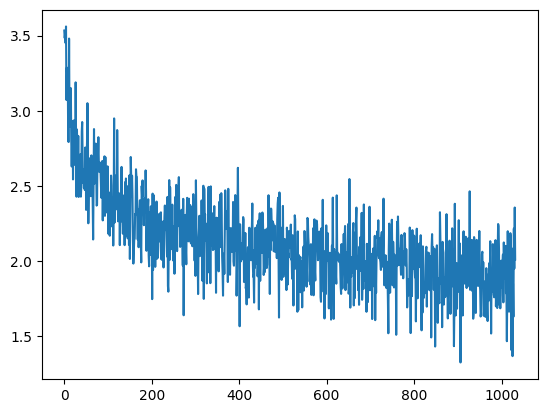

In [5]:
from matplotlib import pyplot as plt

plt.plot([x.detach().cpu().numpy() for x in loss_sample])
plt.show()

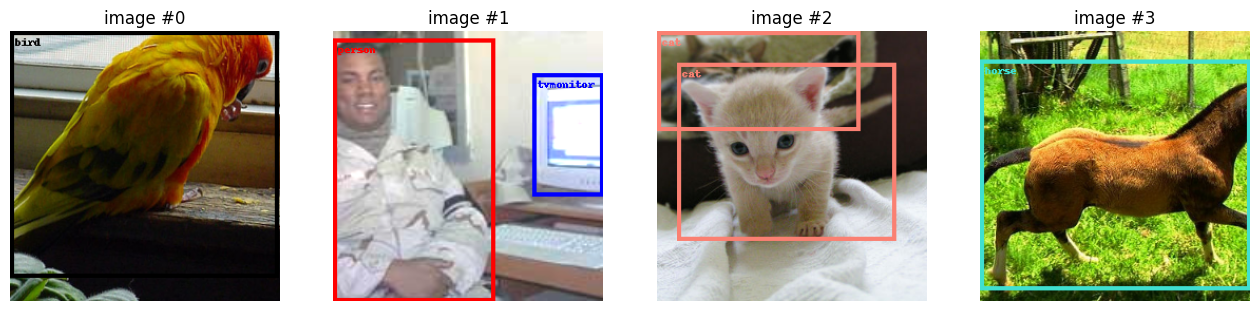

In [6]:
from dataset.visualization import visualize_batch
from dataset.labels_codec import LabelsCodec

visualize_batch(img, boxes, labels, codec=LabelsCodec())

In [7]:
import torch


def draw_predictions(imgs_batch, prediction, labels_codec, threshold=0.01):  
    batch_size = len(imgs_batch)
    
    boxes = [[] for i in range(batch_size)]
    labels = [[] for i in range(batch_size)]
    scores = [[] for i in range(batch_size)]

    pred_ids = prediction['classes']
    pred_scores = prediction['scores']
    pred_boxes = prediction['boxes']

    for img_idx in range(batch_size):
        img_ids = pred_ids[img_idx]
        img_scores = pred_scores[img_idx]
        img_boxes = pred_boxes[img_idx]

        mask = img_scores >= threshold

        filtered_scores = img_scores[mask]
        filtered_labels = img_ids[mask]
        filtered_boxes = img_boxes[mask]

        for score, label, box in zip(filtered_scores, filtered_labels, filtered_boxes):
            scores[img_idx].append(score)
            labels[img_idx].append(label)
            boxes[img_idx].append(box)

    boxes = [
        torch.stack(img_boxes) if len(img_boxes) else torch.zeros((0, 4), dtype=torch.float)
        for img_boxes in boxes
    ]
    scores = [
        torch.stack(img_scores) if len(img_scores) else torch.zeros((0, 1), dtype=torch.float)
        for img_scores in scores
    ]  
    labels = [
        torch.stack(img_labels) if len(img_labels) else torch.zeros((0, 1), dtype=torch.float)
        for img_labels in labels
    ]

    visualize_batch(
        imgs_batch,
        boxes_batch=boxes,
        labels_batch=labels,
        scores_batch=scores,
        codec=labels_codec
    )

In [8]:
eval_model = model.eval().to('cpu')
pred = eval_model(img.to('cpu'))

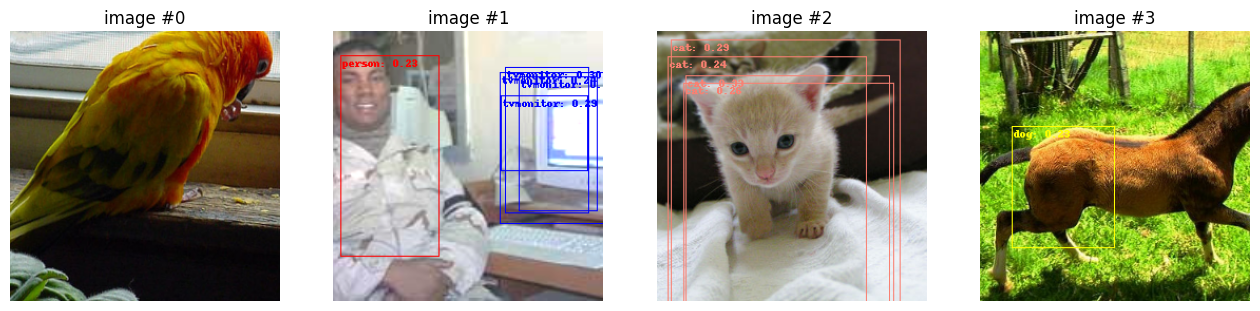

In [14]:
draw_predictions(img.to('cpu'), pred, LabelsCodec(), 0.2)

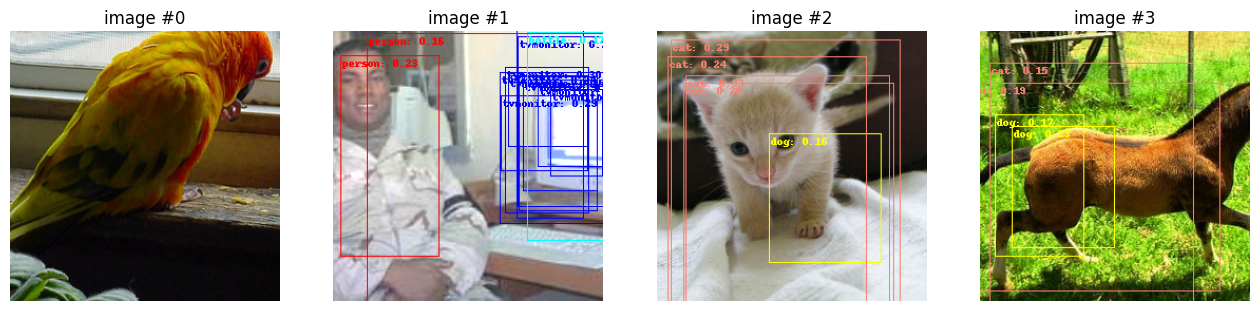

In [15]:
draw_predictions(img.to('cpu'), pred, LabelsCodec(), 0.15)